#### Definition
Boosting is a machine learning algorithm used to improve the accuracy of classification or regression models. The goal of boosting is to combine several weak models to create a strong model.

In summary, boosting works as follows:

1. A weak model is trained using the training data.

2. The data points that the weak model did not classify correctly are identified.

3. The importance of the misclassified data points is increased and the model is retrained.

4. The above process is repeated until a desired level of accuracy is achieved.

The idea behind boosting is that by focusing on the data points that were misclassified, the accuracy of the model can be improved at those specific points. By repeating this process several times, more accurate and powerful models can be created than the original weak models.

A common example of a boosting algorithm is AdaBoost (Adaptive Boosting). AdaBoost uses the boosting technique to create a strong model from several weak models, typically decision trees. AdaBoost is commonly used in binary classification problems, but can also be adapted for regression problems.

#### Examples

Examples of boosting algorithms:

* **AdaBoost (Adaptive Boosting)**: This is one of the most popular boosting algorithms. It works by iteratively training weak models, each time giving more weight to the misclassified data points. AdaBoost combines these weak models into a strong model by assigning more weight to the models that perform better on the training data.

* **Gradient Boosting**: This algorithm works by iteratively adding decision trees to a model. Each new tree is trained to correct the errors of the previous tree. Gradient boosting is particularly effective for regression problems.

* **XGBoost**: This is an optimized version of gradient boosting that is designed to be faster and more accurate. XGBoost includes several regularization techniques to prevent overfitting and improve the performance of the model.

* **LightGBM**: This is another optimized version of gradient boosting that is designed to be even faster than XGBoost. LightGBM uses a novel technique called Gradient-based One-Side Sampling (GOSS) to select the most informative data points for training.

* **CatBoost**: This is a boosting algorithm designed to work well with categorical features. CatBoost includes several techniques to handle missing values and prevent overfitting. It also uses a novel method called ordered boosting to improve the performance of the model.

#### AdaBoost

The AdaBoost algorithm is rooted in the concept of boosting. Boosting operates under the assumption that a group of "weak" classifiers can work together to create a robust classifier through a voting system. A weak classifier is one that only marginally improves upon random chance. Essentially, if a binary label were assigned randomly, we would be correct about 50% of the time, while a weak classifier may only slightly improve upon this, with a success rate of 55% or a similar value in proximity to 50%.

Let's use an example to illustrate this concept:
 
Assume we have a dataset with five observations, each labeled either -1 or 1. Our labels are y = [1, 1, -1, -1, -1], and we have explanatory variables x. In the first round of boosting, we train a weak classifier G₁(x), which makes the following prediction: G₁(x) = [1, -1, -1, 1, -1]. We can observe that the second and fourth observations have been misclassified. In the second round of boosting, we assign weights wᵢ to each observation in our dataset. We will set wᵢ in such a way that the two misclassified observations will have a greater impact on the learning process of a new classifier G₂(x) than the other three observations. This new classifier may misclassify some of the previously correctly classified observations, but it will be better at predicting the challenging ones.

After repeating the process described above M times, we will get a set of M weak classifiers that we can combine in a final, robust meta-classifier G(x). This meta-classifier will allocate a prediction for each observation based on a weighted majority vote, as shown in the formula below:

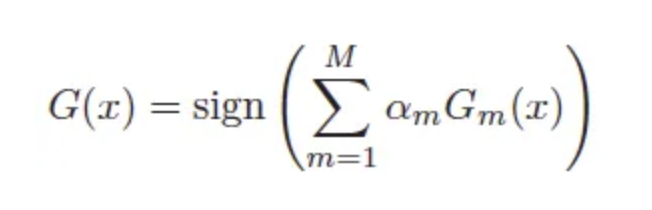

In [42]:
from IPython import display
display.Image("images/AdaClassifier.png")

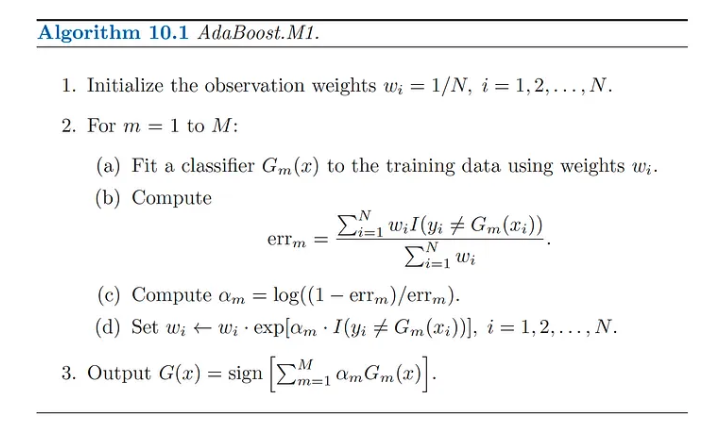

In [41]:
display.Image("images/AdaBoosting.png")

In [54]:
import pandas as pd

In [68]:
# steps 2b,2c:

# Compute error rate, alpha and w
def compute_error(y, y_pred, w_i):
    '''
    Calculate the error rate of a weak classifier m. Arguments:
    y: actual target value
    y_pred: predicted value by weak classifier
    w_i: individual weights for each observation
    
    Note that all arrays should be the same length
    '''
    
    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

def compute_alpha(error):
    '''
    Calculate the weight of a weak classifier m in the majority vote of the final classifier. This is called
    alpha in chapter 10.1 of The Elements of Statistical Learning. Arguments:
    error: error rate from weak classifier m
    '''
    return np.log((1 - error) / error)

def update_weights(w_i, alpha, y, y_pred):
    ''' 
    Update individual weights w_i after a boosting iteration. Arguments:
    w_i: individual weights for each observation
    y: actual target value
    y_pred: predicted value by weak classifier  
    alpha: weight of weak classifier used to estimate y_pred
    '''  
    return w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

In [76]:
class AdaBoost:
    
    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, M = 100):
        '''
        Fit model. Arguments:
        X: independent variables - array-like matrix
        y: target variable - array-like vector
        M: number of boosting rounds. Default is 100 - integer
        '''
        
        # Clear before calling
        self.alphas = [] 
        self.training_errors = []
        self.M = M

        # Iterate over M weak classifiers
        for m in range(0, M):
            
            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                w_i = update_weights(w_i, alpha_m, y, y_pred)
            
            # (a) Fit weak classifier and predict labels
            G_m = DecisionTreeClassifier(max_depth = 1)     # Stump: Two terminal-node classification tree
            G_m.fit(X, y, sample_weight = w_i)
            y_pred = G_m.predict(X)
            
            self.G_M.append(G_m) # Save to list of weak classifiers

            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.G_M) == len(self.alphas)
        
    def predict(self, X):
        '''
        Predict using fitted model. Arguments:
        X: independent variables - array-like
        '''

        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

        # Predict class label for each weak classifier, weighted by alpha_m
        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m

        # Calculate final predictions
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred

In [77]:
# Example
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                           random_state=0, shuffle=False)
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)

clf.predict([[0, 0, 0, 0]])

array([1])

In [78]:
our_clf = AdaBoost()
our_clf.fit(X,y)
our_clf.predict([[0,0,0,0]])

0    1
dtype: int64